In this notebook we will test re-implementing vertex similarity in Cython and numba to improve performance.

As reference: for the MANC dataset we might expect an observation matrix to be up to `(20000, 20000)` and having to do this twice, once for up- and once for downstream connectivity.

In [141]:
import math

import numpy as np
import pandas as pd

import numba

In [2]:
%load_ext Cython

In [3]:
# Numpy reference implementation
def vertex_sim_ref(mat, C1=0.5, C2=1):
    """Calculate vertex similarity between two vectors.
    
    Parameters 
    ----------
    mat :    (N, M) array
             Array of M observations for N neurons. Typically an adjacency matrix. 
    C1,C2 :  float 
             Tuning parameters. 
             
    Returns 
    -------
    (N, N) array 
             Pairwise distances.    
    
    """
    # Create empty array for results
    sims = np.empty(shape=(mat.shape[0], mat.shape[0]), dtype=np.float32)
    for i in range(len(mat)):
        vecA = mat[i]
        for k in range(len(mat)):
            vecB = mat[k]
            # np.minimum is much faster than np.min(np.vstack(vecA, vecB), axis=1) here
            mx = np.maximum(vecA, vecB)
            mn = np.minimum(vecA, vecB)

            # Implement: f(x,y) = min(x,y) - C1 * max(x,y) * e^(-C2 * min(x,y))
            vs = mn - C1 * mx * np.exp(- C2 * mn)

            # Sum over all partners and write to results
            sims[i, k] = vs.sum()
    return sims

In [139]:
%%cython --annotate --force
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp

import numpy as np

cimport cython
from libc.math cimport exp
from cython.parallel import prange


cdef double vsim(double mx, double mn, double C1, double C2) nogil:
    return mn - C1 * mx * exp(- C2 * mn)
    

@cython.boundscheck(False)
@cython.wraparound(False)
def vertex_similarity_c(int[:, ::1] mat, double C1=0.5, double C2=1):
    """Calculate vertex similarity between two vectors."""
    cdef double mx, mn
    cdef int i, k, j
    cdef Py_ssize_t N = mat.shape[0]
    cdef Py_ssize_t M = mat.shape[1]
    
    result = np.zeros((N, N), dtype=float)
    cdef double[:, ::1] result_view = result      

    for i in prange(N, num_threads=10, nogil=True):
        for k in range(N):
            for j in range(M):
                if mat[i, j] > mat[k, j]:
                    mx, mn = mat[i, j], mat[k, j]
                else:
                    mx, mn = mat[k, j], mat[i, j]

                result_view[i, k] += vsim(mx, mn, C1, C2)
                
    return result

In [155]:
@numba.jit(fastmath=True, nopython=True, nogil=True, boundscheck=False, parallel=True)
def vertex_similarity_numba(mat, C1=0.5, C2=1):
    """Calculate vertex similarity between two vectors."""
    sims = np.zeros(shape=(mat.shape[0], mat.shape[0]), dtype=np.float32)
    N = mat.shape[0]
    M = mat.shape[1]
    for i in numba.prange(N):
        for k in range(N):
            for j in range(M):
                if mat[i, j] > mat[k, j]:
                    mx, mn = mat[i, j], mat[k, j]
                else:
                    mx, mn = mat[k, j], mat[i, j]

                sims[i, k] += mn - C1 * mx * math.exp(- C2 * mn)
    return sims

In [148]:
def vertex_similarity_cython(mat, C1=0.5, C2=1):
    assert isinstance(mat, np.ndarray)
    mat = np.ascontiguousarray(mat)
    return np.array(vertex_similarity_c(mat.astype(np.int32),
                                        C1=np.float64(C1),
                                        C2=np.float64(C2)))

In [133]:
# A (1000, 1000) test matrix
np.random.seed(1985)
adj = np.random.randint(0, 100, size=(1000, 1000))

In [134]:
# Test reference implementation
%time _ =  vertex_sim_ref(adj)

20.4 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [138]:
# Test Cython implementation
%time _ = vertex_similarity_cython(adj)

CPU times: user 7.85 s, sys: 10.7 ms, total: 7.86 s
Wall time: 7.86 s


In [ ]:
# Test numba implementation
%time _ = vertex_similarity_numba(adj)

CPU times: user 8.92 s, sys: 6.49 ms, total: 8.92 s
Wall time: 8.94 s


Run a test across various matrix sizes

In [158]:
import time
from tqdm import trange

timings = []
for i in trange(10, 500, 20):
    np.random.seed(1985)
    adj_test = np.random.randint(0, 100, size=(i, 10000))
    
    s = time.time()
    ref = vertex_sim_ref(adj_test)
    t_ref = time.time() - s
    
    s = time.time()
    cy = vertex_similarity_cython(adj_test)
    t_cy = time.time() - s
    
    s = time.time()
    nu = vertex_similarity_numba(adj_test)
    t_nu = time.time() - s    
    
    timings.append([i, t_ref, t_cy, t_nu])
    
timings = pd.DataFrame(timings, columns=['s', 'ref', 'Cython', 'numba'])
timings.head()    

100%|██████████| 25/25 [09:44<00:00, 23.36s/it]


,s,ref,Cython,numba
0,10,0.016018,0.010455,0.012062
1,30,0.122930,0.070579,0.086713
2,50,0.276785,0.190900,0.217356
3,70,0.533512,0.373726,0.435173
4,90,0.870262,0.614841,0.709402


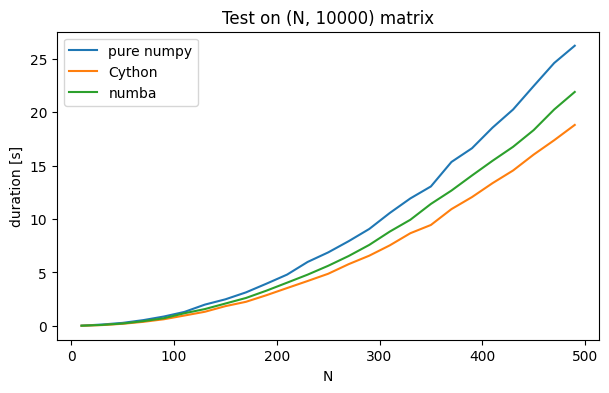

In [159]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(timings.s.values, timings.ref.values, label='pure numpy')
ax.plot(timings.s.values, timings.Cython.values, label='Cython')
ax.plot(timings.s.values, timings.numba.values, label='numba')

ax.set_title('Test on (N, 10000) matrix')
ax.set_ylabel('duration [s]')
ax.set_xlabel('N')

ax.legend()
plt.savefig('benchmark.png', dpi=400)
plt.show()